In [19]:
# !pip install qutip

In [20]:
# Sanity check

# import qutip
# import qutip.testing
# qutip.testing.run()

The process typically takes between 10 and 30 minutes, depending on your system. It is normal for some tests to be skipped or marked as "xfail" (expected fail), especially if optional dependencies are missing or if certain features are not available on your platform. Only failures marked in red ("fail" or "error") indicate real problems

## Single Qubit Drive Testing

Relative drive strength A/wq: 0.25


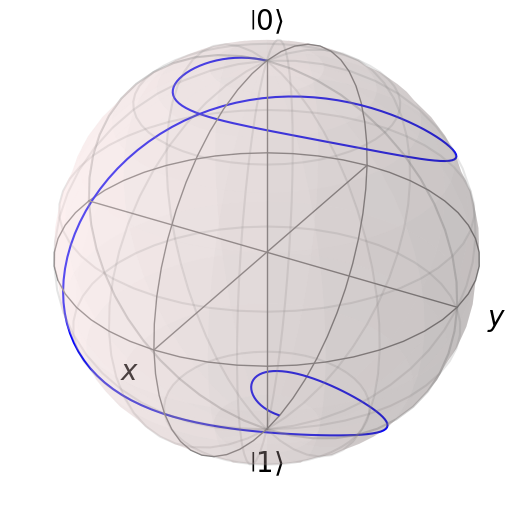

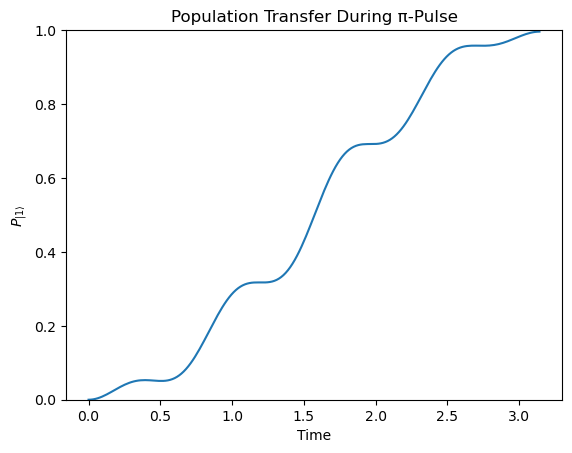

In [36]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parameters
w_q = 4    # Qubit frequency
A = 1      # Drive amplitude

print("Relative drive strength A/wq:", A/w_q)

# Even if you keep wq and wd the same, the relative drive strength A/wq leads to slower Rabi oscillations

w_d = w_q    # Resonant drive

# -----------------------------------------------------------------------------
# In a driven qubit (two-level system), a "π-pulse" is a resonant pulse that
# rotates the qubit state by π radians (180°) on the Bloch sphere, flipping it
# from |0⟩ to |1⟩ or vice versa—a quantum NOT (X) gate.
#
# On resonance (ω_d = ω_q), the Rabi frequency is Ω = A, so the time to achieve
# a π rotation is t_pi = π / A. Applying the drive for this duration ensures a
# perfect state flip. Shorter or longer pulses result in only partial rotation.
# -----------------------------------------------------------------------------

t_pi = np.pi/A  # π-pulse duration
tlist = np.linspace(0, t_pi, 200)

# Initial state: |0⟩
psi0 = qt.basis(2, 0)

# Hamiltonian
def drive_coeff(t, args):
    return A * np.cos(args['w_d'] * t)

H = [w_q/2 * qt.sigmaz(), [qt.sigmax(), drive_coeff]]
args = {'w_d': w_d}

# Solve
result = qt.mesolve(H, psi0, tlist, [], [], args=args)

# Bloch sphere visualization
sx = [qt.expect(qt.sigmax(), state) for state in result.states]
sy = [qt.expect(qt.sigmay(), state) for state in result.states]
sz = [qt.expect(qt.sigmaz(), state) for state in result.states]

b = qt.Bloch()
b.add_points([sx, sy, sz], meth='l')
b.show()

# Corrected population calculation
pop1 = [np.abs(state.overlap(qt.basis(2,1)))**2 for state in result.states]  # FIXED

plt.figure()
plt.plot(tlist, pop1)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel(r'$P_{|1\rangle}$')
plt.title('Population Transfer During π-Pulse')
plt.show()


### Relative Drive Slider Testing

In [49]:
from ipywidgets import interact, FloatSlider

def qubit_drive_sim(rel_drive_strength=1.0):
    """
    Simulate and plot qubit NOT gate dynamics for adjustable relative drive strength (A/w_q).
    Shows initial and final state vectors on the Bloch sphere and prints the final state.
    """
    w_q = 4.0  # Fixed qubit frequency
    A = rel_drive_strength * w_q
    w_d = w_q
    t_pi = np.pi / A
    tlist = np.linspace(0, t_pi, 200)
    psi0 = qt.basis(2, 0)
    
    def drive_coeff(t, args):
        return A * np.cos(args['w_d'] * t)

    H = [w_q/2 * qt.sigmaz(), [qt.sigmax(), drive_coeff]]
    args = {'w_d': w_d}
    result = qt.mesolve(H, psi0, tlist, [], [], args=args)

    sx = [qt.expect(qt.sigmax(), state) for state in result.states]
    sy = [qt.expect(qt.sigmay(), state) for state in result.states]
    sz = [qt.expect(qt.sigmaz(), state) for state in result.states]

    b = qt.Bloch()
    b.add_points([sx, sy, sz], meth='l')
    # Add vector for initial state (north pole)
    b.add_vectors([0, 0, 1])
    # Add vector for final state
    final_state = result.states[-1]
    sx_f = qt.expect(qt.sigmax(), final_state)
    sy_f = qt.expect(qt.sigmay(), final_state)
    sz_f = qt.expect(qt.sigmaz(), final_state)
    b.add_vectors([sx_f, sy_f, sz_f])
    b.show()

    # Print the final state as an array
    print("Final state vector (ket):")
    print(final_state.full())

    pop1 = [np.abs(state.overlap(qt.basis(2,1)))**2 for state in result.states]

    plt.figure()
    plt.plot(tlist, pop1)
    plt.ylim(0, 1)
    plt.xlabel('Time')
    plt.ylabel(r'$P_{|1\rangle}$')
    plt.title(f'Population Transfer (A/w_q = {rel_drive_strength:.2f})')
    plt.show()

# Only the relative drive strength is controlled by the slider
interact(qubit_drive_sim, rel_drive_strength=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05, description='A/w_q'))

# Note:
# The code's imperfection comes from simulating the full physical Hamiltonian, not from modeling noise or hardware errors.

interactive(children=(FloatSlider(value=1.0, description='A/w_q', max=2.0, min=0.1, step=0.05), Output()), _do…

<function __main__.qubit_drive_sim(rel_drive_strength=1.0)>

### RWA Hamiltonian (perfect NOT operation)

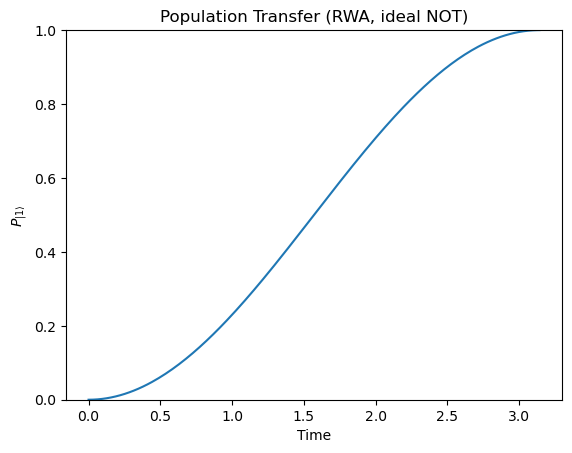

In [ ]:
# RWA Hamiltonian for a perfect NOT
A = 1
t_pi = np.pi/A
tlist = np.linspace(0, t_pi, 200)
psi0 = qt.basis(2, 0)
H_rwa = (A/2) * qt.sigmax()

result = qt.mesolve(H_rwa, psi0, tlist, [], [])
pop1 = [np.abs(state.overlap(qt.basis(2,1)))**2 for state in result.states]

plt.plot(tlist, pop1)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel(r'$P_{|1\rangle}$')
plt.title('Population Transfer (RWA, ideal NOT)')
plt.show()
